In [1]:
import subprocess
import os
import shutil
import warnings

warnings.filterwarnings("ignore")
from ast import literal_eval
import itertools
import matplotlib.pyplot as plt
import toolsets.spectra_operations as so
import seaborn as sns
from tqdm import tqdm
from operator import itemgetter
import time
import numpy as np
import sys
sys.path.append('yuanyue_code')

import re
import pandas as pd
import toolsets.adduct_calculator as acalc
# import spectral_entropy as se

import toolsets.denoising_related_functions as de
import pandas as pd
import toolsets.ms2_spectra_plotter as ms2plotter
%load_ext autoreload
%autoreload 2
import toolsets.mass_to_formula as mtf
import toolsets.precursor_matching as pm
import toolsets.mass_recalibration as mr
# import requests
# import numpy as np

Compile the cython code is highly recommended!
i am ms2 spectra plotter, and I have been sideloaded successfully
I have 2 functions, head to tail plot and ms2 plot
I am precursor matching!
I am mass recalibration, usage: mass_recalibrate(data)
the data column must have columns of mix_label, Average_mz, PRECURSORMZ, msms
the msms should in a string format, e.g. mass1	intensity1
mass2	intensity2
....
the recalibrated column would be msms_recalibrated


In [2]:
data_height = pm.readin_MSDIAL("/Users/fanzhoukong/Documents/GitHub/Libgen_data/dipep/Dipeptides pos1 from MS DIAL.txt")
sample_list = pd.read_csv("/Users/fanzhoukong/Documents/GitHub/Libgen_data/dipep/dipeptides-pos1 standards list.csv")
mass_error = 0.01




# data_hilic = pm.precursor_matching(data_height, sample_list_cor, mass_error, ['[M+H]+', '[M+NH4]+','[M+Na]+'], "EAD_HILIC", ifppm = False)
# data_ead = pd.concat([data_pfp, data_hilic], axis=0)

In [3]:
adductH= []
for index, row in sample_list.iterrows():
    adductH.append(acalc.calculate_precursormz(row['Formula'], '[M+H]+'))

In [5]:
adductH[0:5]

[161.0921, 205.0819, 219.0975, 237.1234, 147.0764]

In [4]:
sample_list['[M+H]+']=adductH

In [7]:
data = pm.precursor_matching(data_height, sample_list, mass_error, ['[M+H]+'], "DIPEP", ifppm= False)

100%|██████████| 33/33 [00:01<00:00, 29.09it/s]


In [9]:
data_r = mr.data_recalibrate(data, save_diff=True)

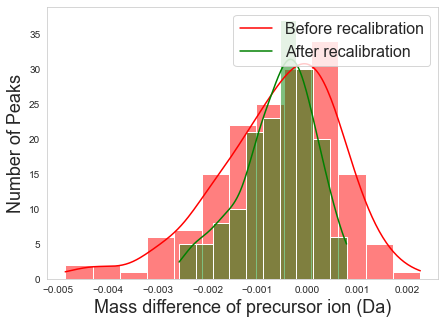

In [11]:
fig, ax = plt.subplots(
    figsize = (7, 5)
                      )
ax= sns.histplot(data=data_r, x="diff_raw", multiple="stack", kde = True, color = "red")
ax = sns.histplot(data=data_r, x="diff_recalibrated", multiple="stack", kde = True,color = "green")
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Mass difference of precursor ion (Da)", fontsize = 18)
ax.set_ylabel("Number of Peaks", fontsize = 18)
ax.grid(False)
plt.legend(labels=["Before recalibration","After recalibration"], loc = 'upper right',fontsize=16)
plt.show()

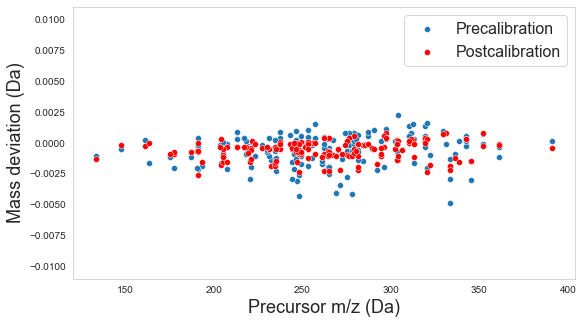

In [31]:
fig, ax = plt.subplots(
    figsize = (9, 5)
                      )
ax= sns.scatterplot(data=data_r, x=data_r['PRECURSORMZ'], y=data_r['diff_raw'])
ax= sns.scatterplot(data=data_r, x=data_r['PRECURSORMZ'], y=data_r['diff_recalibrated'],color = 'red')

# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Precursor m/z (Da)", fontsize = 18)
ax.set_ylabel("Mass deviation (Da)", fontsize = 18)
ax.set_ylim(-0.011, 0.011)
ax.grid(False)
plt.legend(labels=["Precalibration",'Postcalibration'], loc = 'upper right',fontsize=16)
# plt.savefig('data/pre_post_calibration.tiff', dpi = 300,facecolor = 'white', edgecolor = 'white')

In [12]:
data_r_u = so.duplicate_handling(data_r, mass_error = 0.02, ifppm=False)
data_r_u_d = so.denoising(data_r_u,'msms', mass_error = 0.02, ifppm = False)

100%|██████████| 154/154 [00:02<00:00, 64.45it/s] 


i am in new denoising method


100%|██████████| 154/154 [00:11<00:00, 13.02it/s]


In [13]:
data_ead_r_u_d_eva=so.denoising_evaluation(data_r_u_d,msms1 = 'msms', msms2 = 'msms_r_u_d', min_explained_intensity = 70, allowed_max_unassigned_intensity = 30)

In [17]:
data_good_quality = data_ead_r_u_d_eva.loc[data_ead_r_u_d_eva['explained_intensity']>=0.7]

In [27]:
data_better_quality = data_ead_r_u_d_eva.loc[data_ead_r_u_d_eva['explained_intensity']>=0.8]

In [29]:
len(data_good_quality), len(data_better_quality)

(153, 153)

In [21]:
num_peaks_raw = []
num_peaks_de = []
for index, row in data_good_quality.iterrows():
    num_peaks_raw.append(so.num_peaks(row['msms']))
    num_peaks_de.append(so.num_peaks(row['msms_r_u_d']))

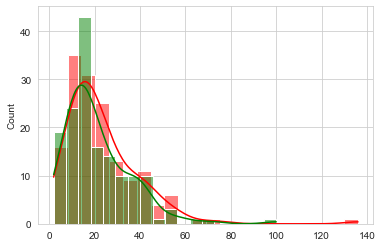

In [22]:
ax= sns.histplot(num_peaks_raw ,multiple="stack", kde = True, color = "red")
ax = sns.histplot(num_peaks_de, multiple="stack", kde = True,color = "green")

In [41]:
max(num_peaks_de)

100

In [23]:
peak_intensity_valid = []
peak_intensity_noise =[]

# num_peaks
for index, row in data_good_quality.iterrows():
    # num_peaks = num_peaks+so.num_peaks(row['msms'])
    mass_temp, intensity_temp = so.break_spectra(row['msms_r_u_d'])
    peak_intensity_valid.extend(intensity_temp)
    intensity_noise_temp = so.identify_unassigned_intensity(row['msms'], row['msms_r_u_d'])
    if intensity_noise_temp!=-1:
        peak_intensity_noise.extend(intensity_noise_temp)

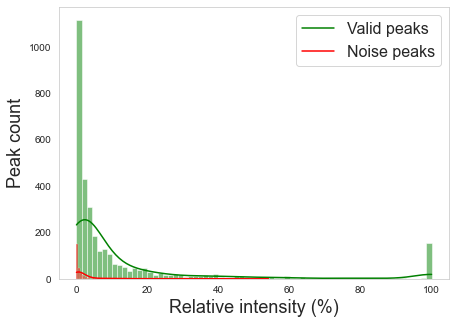

In [24]:
fig, ax = plt.subplots(
    figsize = (7, 5)
                      )
ax= sns.histplot(peak_intensity_valid, multiple="stack", kde = True, color = 'green')
ax = sns.histplot(peak_intensity_noise,  multiple="stack", kde = True,color = 'red')
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Relative intensity (%)", fontsize = 18)
ax.set_ylabel("Peak count", fontsize = 18)
ax.grid(False)
plt.legend(labels=["Valid peaks","Noise peaks"], loc = 'upper right',fontsize=16)
# plt.savefig('data/denoising_better.tiff', dpi = 300,facecolor = 'white', edgecolor = 'white')

In [43]:
for index, row in data_good_quality.iterrows():
    if so.num_peaks(row['msms_r_u_d'])==100:
        print(row)
        break

NAME                                                                     His-Trp
key                                            FBTYOQIYBULKEH-ZFWWWQNUSA-N[M+H]+
PRECURSORMZ                                                             342.1561
InChIKey                                             FBTYOQIYBULKEH-ZFWWWQNUSA-N
Formula                                                               C17H19N5O3
ExactMass                                                               341.1488
Adduct                                                                    [M+H]+
Spectrum_type                                                                MS2
RETENTIONTIME                                                              2.252
Average_mz                                                             342.15582
Comment                                                3707DIPEP intensity 79729
Alignment_ID                                                                3707
ms1                         

In [45]:
pd.Series(peak_intensity_noise).quantile(0.95)

11.340206

In [46]:
pd.Series(peak_intensity_noise).quantile(1-0.95)

0.023883

In [33]:
so.export_library(data_good_quality, "/Users/fanzhoukong/Documents/GitHub/Libgen_data/dipep/dipep_lib.txt", typeofmsms='msms_r_u_d')

In [34]:
normalized_entropy = []
for index, row in data_good_quality.iterrows():
    normalized_entropy.append(so.normalized_entropy(row['msms_r_u_d']))
data_good_quality['normalized_entropy_denoised']=normalized_entropy

In [40]:
len(data_r['InChIKey'].unique())

154

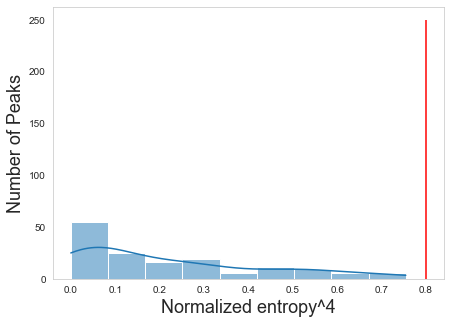

In [36]:
# plotting distribution of normalized entropy, not necessary
fig, ax = plt.subplots(
    figsize = (7, 5)
                      )
ax= sns.histplot(data=data_good_quality, x="normalized_entropy_denoised", kde = True,
                 # hue="evaluations"
                 )
# ax.yaxis
plt.vlines(x =0.8, ymin = 0, ymax=250,colors='red')
# ax = sns.histplot(data=data_ead_r, x="diff_recalibrated", multiple="stack", kde = True,color = "green")
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Normalized entropy^4", fontsize = 18)
ax.set_ylabel("Number of Peaks", fontsize = 18)
ax.grid(False)
# plt.legend(labels=["Before recalibration","After recalibration"], loc = 'upper right')
# plt.savefig('data/normalized_entropy.tiff', dpi = 300,facecolor = 'white', edgecolor = 'white')

In [47]:
sample_list.to_csv("/Users/fanzhoukong/Documents/GitHub/Libgen_data/dipep/std_list_corrected.csv", index = False)

In [48]:
import toolsets.curation_tools as ctools

In [49]:
missing_compounds = ctools.check_for_missing_compounds(data_ead_r_u_d_eva, sample_list)

In [50]:
missing_compounds

,Name,InChIKey,Mix label,Exact Mass,Formula,[M+H]+
1,Ala-Asp,XAEWTDMGFGHWFK-IMJSIDKUSA-N,Dipeptides-pos-G1,204.0746,C7H12N2O5,205.0819
13,Ala-Val,LIWMQSWFLXEGMA-WDSKDSINSA-N,Dipeptides-pos-G2,188.1161,C8H16N2O3,189.1234
21,Asp-Lys,OAMLVOVXNKILLQ-BQBZGAKWSA-N,Dipeptides-pos-G3,261.1325,C10H19N3O5,262.1397
23,Asp-Asn,NaN,Dipeptides-pos-G3,247.0804,C8H13N3O6,248.0877
24,Asp-Pro,UKGGPJNBONZZCM-WDSKDSINSA-N,Dipeptides-pos-G3,230.0903,C9H14N2O5,231.0975
...,...,...,...,...,...,...
263,Tyr-Lys,AOLHUMAVONBBEZ-STQMWFEESA-N,Dipeptides-pos-G33,309.1689,C15H23N3O4,310.1761
264,Tyr-Met,KYPMKDGKAYQCHO-RYUDHWBXSA-N,Dipeptides-pos-G33,312.1144,C14H20N2O4S,313.1217
269,Tyr-Ser,ZSXJENBJGRHKIG-UHFFFAOYSA-N,Dipeptides-pos-G34,268.1059,C12H16N2O5,269.1132
270,Tyr-Thr,MFEVVAXTBZELLL-UHFFFAOYSA-N,Dipeptides-pos-G34,282.1216,C13H18N2O5,283.1288


In [51]:
290.1459+0.01

-0.0010000000000331966

In [59]:
G3 = data_height.loc[data_height['Spectrum reference file name']=='Dipeptides-pos-G2']

In [61]:
data_height[data_height['Average Mz'].between(189.1234-0.01, 189.1234+0.01, inclusive=True)]

,Alignment ID,Average Rt(min),Average Mz,Metabolite name,Adduct type,Post curation result,Fill %,MS/MS assigned,Reference RT,Reference m/z,...,Dipeptides-pos-G33,Dipeptides-pos-G34,Dipeptides-pos-G4,Dipeptides-pos-G5,Dipeptides-pos-G6,Dipeptides-pos-G7,Dipeptides-pos-G8,Dipeptides-pos-G9,1,1.1
763,1107,1.999,189.12090,Unknown,[M+H]+,ion correlated with 1905; ion correlated with ...,0.061,False,NaN,NaN,...,232,44,74,72,70,64,218,81,660.333333,2466.013370
764,1108,1.862,189.12343,Unknown,[M+H]+,NaN,0.152,True,NaN,NaN,...,146,162,234,126,132,193,191901,185,34225.410980,100353.749900
765,1109,1.915,189.13254,Unknown,[M+H]+,NaN,0.030,True,NaN,NaN,...,21,24,32,50,44,51,366,54,226.941288,427.329764
766,1110,2.237,189.13329,Unknown,[M+H]+,NaN,0.030,False,NaN,NaN,...,21,42,32,46,33,52,82,1274,160.329545,337.965795


In [ ]:
sample_list.loc[sample_list['[M+H]+']==]

In [64]:
sample_list[sample_list['[M+H]+'].between(189.1234-0.01, 189.1234+0.01, inclusive=True)]

,Name,InChIKey,Mix label,Exact Mass,Formula,[M+H]+
13,Ala-Val,LIWMQSWFLXEGMA-WDSKDSINSA-N,Dipeptides-pos-G2,188.1161,C8H16N2O3,189.1234
224,Val-Ala,HSRXSKHRSXRCFC-WDSKDSINSA-N,Dipeptides-pos-G29,188.1161,C8H16N2O3,189.1234


In [83]:
data_height.loc[data_height['Average Mz'].between(189.1234-0.01, 189.1234+0.01, inclusive=True)].iloc[:,32:-2].iloc[0]

<bound method NDFrame._add_numeric_operations.<locals>.max of Dipeptides-pos-G1        42
Dipeptides-pos-G10       52
Dipeptides-pos-G11       28
Dipeptides-pos-G13      318
Dipeptides-pos-G14       55
Dipeptides-pos-G15      283
Dipeptides-pos-G16       96
Dipeptides-pos-G17      978
Dipeptides-pos-G18       45
Dipeptides-pos-G19       63
Dipeptides-pos-G2      1652
Dipeptides-pos-G20      242
Dipeptides-pos-G21      108
Dipeptides-pos-G22       52
Dipeptides-pos-G23      112
Dipeptides-pos-G24    14233
Dipeptides-pos-G25      130
Dipeptides-pos-G26       95
Dipeptides-pos-G27     1332
Dipeptides-pos-G28       63
Dipeptides-pos-G29      692
Dipeptides-pos-G3        75
Dipeptides-pos-G30       50
Dipeptides-pos-G31       74
Dipeptides-pos-G32       64
Dipeptides-pos-G33      232
Dipeptides-pos-G34       44
Dipeptides-pos-G4        74
Dipeptides-pos-G5        72
Dipeptides-pos-G6        70
Dipeptides-pos-G7        64
Dipeptides-pos-G8       218
Dipeptides-pos-G9        81
Name: 763, dty

In [84]:
import molmass

In [ ]:
molmass.Formula()

In [67]:
data_height['Dipeptides-pos-G2']

0        8042
1        4623
2       12599
3        4797
4        7187
        ...  
6626        9
6627     2891
6628     3990
6629     1779
6630        9
Name: Dipeptides-pos-G2, Length: 6631, dtype: int64